# TPU DDIM TRC notebook

Run this on a TPU VM - I am using a v3-8 TPU, though others may work just fine (if you have access to a v3-32, I would be very curious to hear how well it scales)

# Basic setup

Set up TPU, import libraries

In [1]:
# Set JAX, flax and optax up for the TPU
!pip install --upgrade -q jaxlib optax tqdm
!pip install --upgrade flax
!pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import math

import jax
import jax.numpy as jnp
from jax import jit, lax
from jax import nn as jnn
from jax import random as jr
import functools

import flax
import flax.linen as nn
from flax.core import freeze, unfreeze

from typing import Any, Callable, Sequence, Optional

from jax.experimental.maps import xmap, mesh
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental import stax

import optax
import tqdm

import pickle

# Pinky promise: We are now aware xmap is experimental, and will adjust our expectations accordingly
import warnings
warnings.filterwarnings("ignore", message="xmap is an experimental feature and probably has bugs!")

In [4]:
# Generate PRNG state
prng = jr.PRNGKey(23)

# Blocks for a diffusion model

### Timestep embedding, block sequencing

In [5]:
class TimeEmbed(nn.Module):
    """
    Timestep embedding module
    """
    time_embed_dim: int
    max_period: int
    project_embed_dim: int
    embed_dtype: jnp.dtype = jnp.float32

    @nn.compact
    def __call__(self, timesteps):
        # Calculate sinusodial embedding
        half = self.time_embed_dim // 2
        freqs = jnp.exp(-math.log(self.max_period) * jnp.arange(0, half) / half)
        args = timesteps[:, None].astype(self.embed_dtype) * freqs[None]
        embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis = -1)
        if self.time_embed_dim % 2:
            embedding = jnp.concatenate([embedding, jnp.zeros(embedding[:, :1].shape)], axis = -1)

        # Some dense layers to properly embed for real
        embedding = nn.Dense(self.project_embed_dim)(embedding)
        embedding = nn.silu(embedding)
        embedding = nn.Dense(self.project_embed_dim)(embedding)
        
        return embedding

class TimestepBlock(nn.Module):
    """
    Interface for modules that can take timestep embeddings as input
    in addition to regular embeddings.
    """
    def __call__(self, x, emb):
        pass

class TimestepEmbedSequential(TimestepBlock):
    """
    Block that passes timestep embeddings to all submodules that
    want them.

    Also works as a regular sequential type module
    """
    layers: Sequence[nn.Module]

    @nn.compact
    def __call__(self, x, emb = None):
        for layer in self.layers:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

class TimestepBlockTest(TimestepBlock):
    """
    Dummy block for testing
    """
    @nn.compact
    def __call__(self, x, emb):
        return x

In [6]:
# Lets see if it works
"""
embed_test = TimeEmbed(16, 10000, 16 * 4)
embed_in = jnp.zeros((10, 1))
params = embed_test.init(prng, embed_in)
embed_test.apply(params, embed_in).shape
"""

'\nembed_test = TimeEmbed(16, 10000, 16 * 4)\nembed_in = jnp.zeros((10, 1))\nparams = embed_test.init(prng, embed_in)\nembed_test.apply(params, embed_in).shape\n'

### Convolution, pooling and identity

In [7]:
class ConvND(nn.Module):
    """
    n-D convolution with square kernel
    """
    dims: int
    out_channels: int
    kernel_size: int
    stride: int = 1
    padding: int = 'SAME'

    def setup(self):
        self.kernel = tuple([self.kernel_size] * self.dims)
        self.strides = tuple([self.stride] * self.dims)
        if self.padding in ['SAME', 'VALID']:
            self.paddings = self.padding
        else:
            self.paddings = tuple([(self.padding, self.padding)] * self.dims)
        self.conv = nn.Conv(self.out_channels, self.kernel, self.strides, self.paddings)

    def __call__(self, x):
        return self.conv(x)

class AvgND(nn.Module):
    """
    n-D average pooling with square window

    Numeric padding is NOT supported, specify either SAME or VALID padding.
    """
    dims: int
    window_size: int = 2
    stride: int = 2
    padding: int = 'VALID'

    def setup(self):
        self.window = [1] + [self.window_size] * self.dims
        self.strides = [1] + [self.stride] * self.dims
        if self.padding in ['SAME', 'VALID']:
            self.paddings = self.padding

    def __call__(self, x):
        full_window = tuple(list(self.window) + list([1] * (len(x.shape) - len(self.window) - 1)))
        full_strides = tuple(list(self.strides) + list([1] * (len(x.shape) - len(self.window) - 1)))
        return nn.avg_pool(x, full_window, full_strides, self.paddings)

class Identity(nn.Module):
  """
  For model building convenience, a class that does nothing
  """
  @nn.compact
  def __call__(self, x):
      return x

### Up- and Downsampling

In [8]:
class Scale2X(nn.Module):
  """
  nD 2x nearest neighbour scaling
  """
  dims: int
  
  @nn.compact
  def __call__(self, x):
      for i in range(1, self.dims + 1):
          x = jnp.repeat(x, 2, axis = i)
      return x

class Upsample(nn.Module):
    """
    Upsampling layer, factor 2

    Nearest neighour (element repeating), optionally with a convolution afterwards.
    """
    dims: int
    out_channels: int = 0
    use_conv: bool = False

    def setup(self):
        self.scale = Scale2X(self.dims)
        if self.use_conv:
            assert self.out_channels != 0
            self.conv = ConvND(self.dims, self.out_channels, 3)
        else:
            self.conv = Identity()

    def __call__(self, x):
        x = self.scale(x)
        x = self.conv(x)
        return x

class Downsample(nn.Module):
    """
    Downsampling layer, factor 2

    Uses either average pooling (default) or a strided convolution.
    """
    dims: int
    out_channels: int = 0
    use_conv: bool = False

    def setup(self):
        if self.use_conv:
            assert self.out_channels != 0
            self.downsample = ConvND(self.dims, self.out_channels, 3, stride=2, padding=1)
        else:
            self.downsample = AvgND(self.dims)

    def __call__(self, x):
        x = self.downsample(x)
        return x

### Residual block

In [9]:
class ResBlock(TimestepBlock):
    """
    Residual block with timesteps
    """
    dims: int
    in_channels: int
    out_channels: int
    dropout: float
    use_conv: bool = False
    up: bool = False
    down: bool = False
    use_scale_shift_norm: bool = False

    def setup(self):
        # Initial normalization block
        self.in_block = TimestepEmbedSequential((
            nn.GroupNorm(epsilon=1e-05),
            nn.silu,
        ))

        # Up/Downsampling block
        if self.up:
            self.h_upd = Upsample(self.dims) 
            self.x_upd = Upsample(self.dims)
        elif self.down:
            self.h_upd = Downsample(self.dims)
            self.x_upd = Downsample(self.dims)
        else:
            self.h_upd = self.x_upd = Identity()

        # Input convolution
        self.in_conv = ConvND(self.dims, self.out_channels, 3)

        # Embedding projection block
        self.embed_project = TimestepEmbedSequential((
            nn.silu,
            nn.Dense(2 * self.out_channels if self.use_scale_shift_norm else self.out_channels)
        ))

        # Actual layer stack
        self.out_norm = nn.GroupNorm(epsilon=1e-05)
        self.out_layers = TimestepEmbedSequential((
            nn.silu,
            nn.Dropout(self.dropout, deterministic=True), # TODO: This should be dynamic, for training. Right now it's a noop.
            ConvND(self.dims, self.out_channels, 3) # There was a zero initializer (?) here, it's gone now, sorry. Maybe not important.
        ))

        # Channel change for skip connection
        if self.out_channels == self.in_channels:
            self.skip_connection = Identity()
        elif self.use_conv:
            self.skip_connection = ConvND(self.dims, self.out_channels, 3)
        else:
            self.skip_connection = ConvND(self.dims, self.out_channels, 1)

    def __call__(self, x, emb):
        # For residual: Resample x
        x_res = self.x_upd(x)

        # Run x through input & up/downsample block
        x = self.in_block(x)
        x = self.h_upd(x)
        x = self.in_conv(x)
            
        # Project embedding and unsqueeze up to match shape of x
        emb_out = self.embed_project(emb.reshape(emb.shape[0], -1))
        emb_out = emb_out.reshape((emb_out.shape[0],) + tuple([1] * (len(x.shape) - len(emb_out.shape))) + (emb_out.shape[-1],))
        
        # Apply actual convolution
        if self.use_scale_shift_norm:
            scale = emb_out[..., :self.out_channels]
            shift = emb_out[..., self.out_channels:]
            x = self.out_norm(x) * (1 + scale) + shift
            x = self.out_layers(x)
        else:
            x = x + emb_out
            x = self.out_norm(x)
            x = self.out_layers(x)

        # Return residual
        return self.skip_connection(x_res) + x

In [10]:
# Lets see if it works
"""
conv = ResBlock(2, 64, 128, .5, up=True, use_conv=False, use_scale_shift_norm=True)
conv_in = jnp.zeros((10, 20, 20, 64))
params = conv.init(prng, conv_in, conv_in)
conv.apply(params, conv_in, conv_in).shape
"""

'\nconv = ResBlock(2, 64, 128, .5, up=True, use_conv=False, use_scale_shift_norm=True)\nconv_in = jnp.zeros((10, 20, 20, 64))\nparams = conv.init(prng, conv_in, conv_in)\nconv.apply(params, conv_in, conv_in).shape\n'

### Attention block

In [11]:
class SpatialSelfAttentionBlock(nn.Module):
    """
    Dot-product attention block for spatial dimensions
    """
    head_channels: int = 64
    
    @nn.compact
    def __call__(self, x):
        # Flatten out spatial channels and norm
        batches = x.shape[0]
        channels = x.shape[-1]
        x_in = x.reshape((batches, -1, channels))
        qkv = nn.GroupNorm(epsilon=1e-05)(x_in)

        # Convolve to three times the amount of channels and split into query, key and value
        qkv = ConvND(1, channels * 3, 1)(qkv)

        # Calculate number of heads and split into heads
        heads = int(channels / self.head_channels)
        qkv = qkv.reshape(batches, -1, heads, self.head_channels * 3)

        # Split into query/key/value
        query = qkv[:, :, :, 0:self.head_channels] 
        key = qkv[:, :, :, self.head_channels:self.head_channels*2]
        value = qkv[:, :, :, self.head_channels*2:]

        # Calculate dot product attention and flatten out
        x_out = nn.dot_product_attention(query, key, value, deterministic=True)
        x_out = x_out.reshape((batches, -1, channels))

        # Project
        x_out = ConvND(1, channels, 1)(x_out)

        # Resicual and reshape back to original shape
        return (x_in + x_out).reshape(x.shape)

In [12]:
# Lets see if it works
"""
attention = SpatialSelfAttentionBlock(64)
attention_in = jnp.zeros((10, 20, 30, 256))
params = attention.init(prng, attention_in)
attention.apply(params, attention_in).shape
"""

'\nattention = SpatialSelfAttentionBlock(64)\nattention_in = jnp.zeros((10, 20, 30, 256))\nparams = attention.init(prng, attention_in)\nattention.apply(params, attention_in).shape\n'

# The actual model


In [13]:
class UNet(nn.Module):
    """
    Unet style model with spatial self attention.
    Unconditional only, for now.
    """
    dims: int
    model_channels: int
    channel_mult: int
    use_scale_shift_norm: bool
    dropout: float
    num_head_channels: int
    num_res_blocks: int
    attention_resolutions: Sequence[int]
    out_channels: int

    def setup(self):
        # Timestep embedding
        time_embed_dim = self.model_channels * 4
        self.time_embed = TimeEmbed(self.model_channels, 10000, time_embed_dim)

        # Initial block for input stack
        input_block_out_channels = int(self.channel_mult[0] * self.model_channels)
        input_blocks = [TimestepEmbedSequential([ConvND(self.dims, input_block_out_channels, 3, padding = 1)])]

        # Loop to create rest of input stack
        current_channels = input_ch = int(self.channel_mult[0] * self.model_channels)
        input_block_chans = [current_channels]
        downsample_fact = 1
        for level, mult in enumerate(self.channel_mult):
            for _ in range(self.num_res_blocks):
                # One res block
                layers = [ResBlock(self.dims, current_channels, int(mult * self.model_channels), dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm)]
                current_channels = int(mult * self.model_channels)

                # One attention block, if requested
                if downsample_fact in self.attention_resolutions:
                    layers.append(SpatialSelfAttentionBlock(self.num_head_channels))

                # Put those in sequence
                input_blocks.append(TimestepEmbedSequential(layers))
                input_block_chans.append(current_channels)

            # Downsample if not the final block
            if level != len(self.channel_mult) - 1:
                input_blocks.append(ResBlock(self.dims, current_channels, current_channels, dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm, down = True))
                input_block_chans.append(current_channels)
                downsample_fact *= 2             
        self.input_blocks = input_blocks

        # Middle block
        self.middle_block = TimestepEmbedSequential([
            ResBlock(self.dims, current_channels, current_channels, self.dropout, use_scale_shift_norm = self.use_scale_shift_norm),
            SpatialSelfAttentionBlock(self.num_head_channels),
            ResBlock(self.dims, current_channels, current_channels, self.dropout, use_scale_shift_norm = self.use_scale_shift_norm),
        ])

        # Output blocks
        output_blocks = []
        for level, mult in list(enumerate(self.channel_mult))[::-1]:
            for i in range(self.num_res_blocks + 1):
                # One res block, with skip input from same unet level
                skip_channels = input_block_chans.pop()
                in_channels = current_channels + skip_channels
                layers = [ResBlock(self.dims, in_channels, int(self.model_channels * mult), dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm)]
                current_channels = int(self.model_channels * mult)

                # One attention block, if requested
                if downsample_fact in self.attention_resolutions:
                    layers.append(SpatialSelfAttentionBlock(self.num_head_channels))
                    
                # Upsample, if not the final block
                if level != 0 and i == self.num_res_blocks:
                    out_ch = current_channels
                    layers.append(ResBlock(self.dims, current_channels, current_channels, dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm, up = True))
                    downsample_fact //= 2
                output_blocks.append(TimestepEmbedSequential(layers))
        self.output_blocks = output_blocks

        # Final output block
        self.out = TimestepEmbedSequential([
            nn.GroupNorm(),
            nn.silu,
            ConvND(self.dims, self.out_channels, 3),
        ])

    # Left / input side of fotward pass
    def forward_in(self, x, t):
        emb = self.time_embed(t)

        h = x
        hs = []
        for block in self.input_blocks:
            h = block(h, emb)
            hs.append(h)

        h = self.middle_block(h, emb)
        return h, emb, hs
        
    # Right / output side of forward pass
    def forward_out(self, h, emb, hs):
        for i in range(len(self.output_blocks)):
            h = jnp.concatenate([h, hs[len(self.output_blocks) - i - 1]], axis = -1)
            h = self.output_blocks[i](h, emb)
        h = self.out(h)
        return h

    # Full forward pass
    def __call__(self, x, t):
        emb = self.time_embed(t)

        h = x
        hs = []
        for block in self.input_blocks:
            h = block(h, emb)
            hs.append(h)

        h = self.middle_block(h, emb)

        for block in self.output_blocks:
            h = jnp.concatenate([h, hs.pop()], axis = -1)
            h = block(h, emb)

        h = self.out(h)
        return h

# Helper function for the channel multipliers from the OpenAI guided diffusion model.
def get_default_channel_mult(image_size):
    channel_mult = None
    if image_size == 512:
        channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
    elif image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    else:
        raise ValueError(f"unsupported image size: {image_size}")
    return channel_mult

In [14]:
# Lets see if it works, by instantiating parameters for a 256x256 model that matches OpenAIs
unet = UNet(
    dims = 2,
    model_channels = 256,
    channel_mult = get_default_channel_mult(256),
    use_scale_shift_norm = True,
    dropout = 0.0,
    num_head_channels = 64,
    num_res_blocks = 2,
    attention_resolutions = (32, 16, 8),
    out_channels = 6
)
image_in = jnp.zeros((1, 256, 256, 3))
embed_in = jnp.zeros((1,))

# To instantiate a new model (for training, or loading pytorch params, or renaming parameters after jit-ing parts of the model)
#params = unet.init(prng, image_in, embed_in)

In [15]:
# Init, but sharded
"""
in_partition = [
    None,
    PartitionSpec("batch", "x", "y"),
    PartitionSpec("batch")
]
out_partition = PartitionSpec(None)
init_pjit = pjit(unet.init, in_partition, out_partition)
devices = np.array(jax.devices()).reshape((1, 4, 2))
with mesh(devices, ('batch', 'x', 'y')):
    params_pjit = init_pjit(prng, image_in, embed_in)
"""

'\nin_partition = [\n    None,\n    PartitionSpec("batch", "x", "y"),\n    PartitionSpec("batch")\n]\nout_partition = PartitionSpec(None)\ninit_pjit = pjit(unet.init, in_partition, out_partition)\ndevices = np.array(jax.devices()).reshape((1, 4, 2))\nwith mesh(devices, (\'batch\', \'x\', \'y\')):\n    params_pjit = init_pjit(prng, image_in, embed_in)\n'

In [16]:
# Or we can just load a pickled set of params
import os
if not os.path.exists("openai_256x256_diffusion_uncond.pkl"):
    !sudo pip install gdown
    !gdown 'https://drive.google.com/uc?export=download&id=1ZpNkKk8BfjLkhiSfFz7DXl4dsjwdrgVH' -O openai_256x256_diffusion_uncond.pkl

In [17]:
with open("openai_256x256_diffusion_uncond.pkl", "rb") as f:
    params_load = pickle.load(f)

In [18]:
# Replicate loaded parameters
devices = np.array(jax.devices()).reshape((1, 4, 2))
with mesh(devices, ('batch', 'x', 'y')):
    shard_params = pjit(lambda x: x,  PartitionSpec(None),  PartitionSpec(None))(params_load)

/home/lorenzd/.local/lib/python3.8/site-packages/jax/experimental/pjit.py:160: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")


In [19]:
# Basic sharded forward pass
def forward_pass(params, image_in, embed_in):
    return unet.apply(params, image_in, embed_in)

in_partition = [
    None,
    PartitionSpec("batch", "x", "y"),
    PartitionSpec("batch")
]
out_partition = PartitionSpec("batch")
forward_pass_pjit = pjit(forward_pass, in_partition, out_partition)

devices = np.array(jax.devices()).reshape((1, 4, 2))
with mesh(devices, ('batch', 'x', 'y')):
    out = forward_pass_pjit(shard_params, image_in, embed_in)

In [20]:
import time

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.26it/s]


49.45638561248779


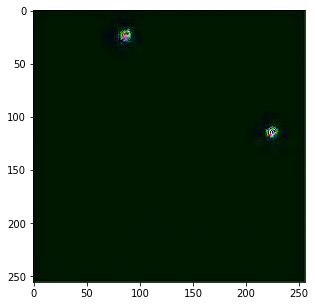

In [21]:
# And now: 1000 times
start = time.time()
image_out = image_in # TODO real input
with mesh(devices, ('batch', 'x', 'y')):
    for i in tqdm.tqdm(range(1000)):
        out = forward_pass_pjit(shard_params, image_out, embed_in) # TODO timesteps
        image_out = out[:, :, :, :3] # Remove extra dimensions
    image_out
    
plt.figure(figsize=(5, 5))
plt.imshow(image_out[0,:,:,:])
print(time.time() - start)

In [22]:
# Forward pass with fori_loop, to run the entire thing on device with no sync
def run_inference(params, image_in_0, embed_in):
    def one_step(i, image_in_step):
        out = forward_pass(params, image_in_step, embed_in)
        return out[:, :, :, :3] # Remove extra dimensions
    return jax.lax.fori_loop(0, 1000, one_step, image_in_0)

in_partition = [
    None,
    PartitionSpec("batch", "x", "y"),
    PartitionSpec("batch")
]
out_partition = PartitionSpec("batch")
run_inference_pjit = pjit(run_inference, in_partition, out_partition)

with mesh(devices, ('batch', 'x', 'y')):
    out = run_inference_pjit(shard_params, image_in, embed_in)

52.15756607055664


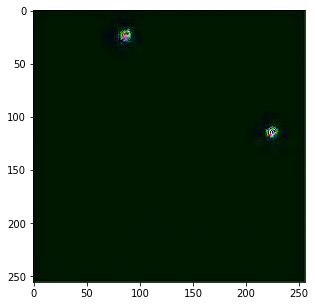

In [23]:
# We fast now boys (maybe)
start = time.time()
with mesh(devices, ('batch', 'x', 'y')):
    out = run_inference_pjit(shard_params, image_in, embed_in)

plt.figure(figsize=(5, 5))
plt.imshow(image_out[0,:,:,:])
print(time.time() - start)

In [24]:
def linear_beta_schedule(steps):
    scale = 1000 / steps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return jnp.linspace(beta_start, beta_end, steps)

betas = linear_beta_schedule(1000)
alphas = 1.0 - betas
alphas_cumprod = jnp.cumprod(alphas, axis=0)
alphas_cumprod_prev = jnp.append(1.0, alphas_cumprod[:-1])
alphas_cumprod_next = jnp.append(alphas_cumprod[1:], 0.0)

sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = jnp.sqrt(1.0 - alphas_cumprod)
log_one_minus_alphas_cumprod = jnp.log(1.0 - alphas_cumprod)
sqrt_recip_alphas_cumprod = jnp.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = jnp.sqrt(1.0 / alphas_cumprod - 1)

posterior_variance = (betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))
posterior_log_variance_clipped = jnp.log(np.append(posterior_variance[1], posterior_variance[1:]))

In [25]:
# Actual denoising loop code
def p_mean_variance(params, images_in, timesteps_in, rescale_timesteps = 1000.0):
    timesteps_scaled = timesteps_in * (1000.0 / rescale_timesteps)
    model_output = forward_pass_pjit(params, images_in, timesteps_scaled)
    
    image_output = model_output[:, :, :, :3]
    var_values = model_output[:, :, :, 3:]
    
    min_log = posterior_log_variance_clipped[timesteps_in]
    max_log = betas[timesteps_in]
    sqrt_recip_alphas_cumprod_step =  sqrt_recip_alphas_cumprod[timesteps_in]
    sqrt_recipm1_alphas_cumprod_step = sqrt_recipm1_alphas_cumprod[timesteps_in]
    
    frac = (var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    model_variance = jnp.exp(model_log_variance)
    
    pred_xstart = sqrt_recip_alphas_cumprod_step * images_in - sqrt_recipm1_alphas_cumprod_step * image_output
    pred_xstart = jax.lax.clamp(-1.0, pred_xstart, 1.0)

    return pred_xstart

def ddim_sample(params, images_in, timesteps_in):
    out = p_mean_variance(params, images_in, timesteps_in)
    
    sqrt_recip_alphas_cumprod_step = sqrt_recip_alphas_cumprod[timesteps_in]
    sqrt_recipm1_alphas_cumprod_step = sqrt_recipm1_alphas_cumprod[timesteps_in]
    eps = (sqrt_recip_alphas_cumprod_step * images_in - out) / sqrt_recipm1_alphas_cumprod_step

    alpha_bar = alphas_cumprod[timesteps_in]
    alpha_bar_prev = alphas_cumprod_prev[timesteps_in]
    mean_pred = (out * jnp.sqrt(alpha_bar_prev) + jnp.sqrt(1 - alpha_bar_prev) * eps)

    return mean_pred

def denoising_loop(params, in_img, steps_total = 1000, from_step = 0, to_step = 1000):
    steps = list(range(steps_total))[::-1]
    steps = steps[from_step:to_step]
    out = in_img
    for i in steps:
        t = jnp.array([i])
        out = ddim_sample(params, out, t)
    return out

def denoising_loop_ondevice(params, image_in_0):
    def one_step(i, image_in_step):
        embed_in = jnp.array([999 - i])
        return ddim_sample(params, image_in_step, embed_in)
    return jax.lax.fori_loop(0, 1000, one_step, image_in_0)
denoising_loop_ondevice = pjit(denoising_loop_ondevice, [PartitionSpec(None), PartitionSpec("batch", "x", "y")], PartitionSpec("batch"))

def sample_to_img(sample):
    sample_img = jax.lax.clamp(0.0, ((sample + 1) * 127.5), 255.0).astype(jnp.uint8)
    return sample_img 

70.84356594085693


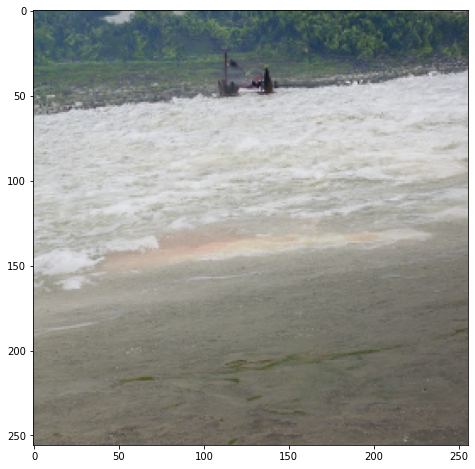

In [26]:
# First attempt at actually sampling
start = time.time()
images_im = jax.random.normal(prng, (1, 256, 256, 3))
timesteps_in = jnp.array([0,], dtype=jnp.int32)
devices = np.array(jax.devices()).reshape((1, 4, 2))
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop(shard_params, images_im)
image = sample_to_img(out)[0, :, :, :].transpose(1, 0, 2)
plt.figure(figsize=(8, 8))
plt.imshow(image)
print(time.time() - start)

In [ ]:
# Second attempt at actually sampling - all on device variant
start = time.time()
images_im = jax.random.normal(prng, (1, 256, 256, 3))
timesteps_in = jnp.array([0,], dtype=jnp.int32)
devices = np.array(jax.devices()).reshape((1, 4, 2))
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop_ondevice(shard_params, images_im)
image = sample_to_img(out)[0, :, :, :].transpose(1, 0, 2)
plt.figure(figsize=(8, 8))
plt.imshow(image)
print(time.time() - start)

In [ ]:
import random
prng_img = jr.PRNGKey(random.randint(0, 2**32))

In [ ]:
# Run it again - this time, already compiled
start = time.time()
images_im = jax.random.normal(prng_img, (1, 256, 256, 3))
timesteps_in = jnp.array([0,], dtype=jnp.int32)
devices = np.array(jax.devices()).reshape((1, 4, 2))
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop_ondevice(shard_params, images_im)
image = sample_to_img(out)[0, :, :, :].transpose(1, 0, 2)
plt.figure(figsize=(8, 8))
plt.imshow(image)
print(time.time() - start)